# Supervised Macroeconomic Index for IFRS9 Forward-Looking Modeling

## Python Implementation of the R Package `smi`

**Author:** Andrija Djurovic (Original R Package)  
**Python Implementation:** Based on the SMI R Package Manual

This notebook reproduces the results from the R package `smi` for constructing the Supervised Macroeconomic Index (SMI) used in IFRS9 Forward-Looking Modeling.

## 1. IFRS9 Forward-Looking Modeling in Practice

IFRS9 requires that estimates of expected credit losses incorporate future reasonable and supportable information. In practice, this involves evaluating how the macroeconomic environment affects risk parameters, typically by regressing default rates against macroeconomic indicators.

Most FLI implementations rely on Ordinary Least Squares (OLS) regression with approaches including:
- OLS regression with/without time lags
- OLS with autoregressive terms
- Two-step error correction models
- Principal Component Analysis (PCA) combined with OLS
- OLS with transformations (logit, probit)

## 2. Libraries and Setup

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from itertools import combinations, product
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.8f}'.format)

## 3. Supervised Macroeconomic Index (SMI) Framework

The SMI addresses key FLI challenges:
1. Low ratio between observations and predictors
2. Incorporation of business-guided macroeconomic indicators
3. Control over expected relationships (signs) between indicators and target
4. Model stability through averaging

The core optimization problem is constrained OLS:

$$\min_{\beta} \sum_{i=1}^{T} (y_i - x_i'\beta)^2$$

Subject to:
- $\beta_j \geq 0$ for $j \in P$ (positive expected relationship)
- $\beta_k \leq 0$ for $k \in N$ (negative expected relationship)

## 4. Case Study

### 4.1 Simulation Dataset: Import and Overview

In [2]:
# Import dataset from GitHub
url = "https://raw.githubusercontent.com/andrija-djurovic/adsfcr/main/model_dev_and_vld/smi_r/db_smi_package.csv"
db = pd.read_csv(url)

# Note: When using 4 lags, the first 4 observations (all of 2011) will have NaN values
# and will be excluded from model estimation. This matches the R package behavior:
# '(4 observations deleted due to missingness)'

# Convert QUARTER to datetime
db['QUARTER'] = pd.to_datetime(db['QUARTER'], format='%d-%m-%y')

# Display structure
print(f"Dataset: {db.shape[0]} observations, {db.shape[1]} columns")
print(f"Period: {db['QUARTER'].min().strftime('%Y-%m-%d')} to {db['QUARTER'].max().strftime('%Y-%m-%d')}")
print("\nColumn dtypes:")
print(db.dtypes)
print("\nFirst 5 rows:")
db.head()

Dataset: 70 observations, 8 columns
Period: 2011-03-31 to 2028-06-30

Column dtypes:
QUARTER    datetime64[ns]
TYPE               object
ODR               float64
UNEMP             float64
GDP               float64
WAGE              float64
EURIBOR           float64
DUMMY               int64
dtype: object

First 5 rows:


,QUARTER,TYPE,ODR,UNEMP,GDP,WAGE,EURIBOR,DUMMY
0,2011-03-31,REALIZED,0.09207744,0.07110738,0.00978754,0.05632530,0.06375087,0
1,2011-06-30,REALIZED,0.09304442,0.07595347,-0.00389711,0.05624907,0.06763877,0
2,2011-09-30,REALIZED,0.09582172,0.07885760,-0.02548600,0.02039205,0.05789377,0
3,2011-12-31,REALIZED,0.10315914,0.07919197,-0.06163630,0.00944951,0.03889726,0
4,2012-03-31,REALIZED,0.11019400,0.08368721,-0.05392225,-0.00198779,0.03488044,0


In [3]:
# Check data types and values
print("TYPE distribution:")
print(db['TYPE'].value_counts())
print(f"\nRealized observations: {(db['TYPE'] == 'REALIZED').sum()}")
print(f"Forecast observations: {(db['TYPE'] == 'FORECAST').sum()}")

TYPE distribution:
TYPE
REALIZED    58
FORECAST    12
Name: count, dtype: int64

Realized observations: 58
Forecast observations: 12


**Dataset Variables:**
- **QUARTER**: Date of observations
- **TYPE**: REALIZED or FORECAST
- **ODR**: Observed Default Rate (target variable)
- **UNEMP**: Unemployment rate
- **GDP**: Year-on-year GDP growth
- **WAGE**: Year-over-year wage growth
- **EURIBOR**: 6-month Euribor value
- **DUMMY**: 0/1 indicator for internal credit risk process change (Q1 2021)

### 4.2 Modeling Inputs

In [4]:
# Define predictors
pn = ["UNEMP", "GDP", "WAGE", "EURIBOR"]

# Define expected signs
# UNEMP: + (higher unemployment -> higher default rates)
# GDP: - (higher GDP growth -> lower default rates)
# WAGE: - (higher wage growth -> lower default rates)
# EURIBOR: + (higher interest rates -> higher default rates)
ps = {
    "UNEMP": "+",
    "GDP": "-",
    "WAGE": "-",
    "EURIBOR": "+"
}

# Define number of lags for each predictor
pl = {
    "UNEMP": 4,
    "GDP": 4,
    "WAGE": 4,
    "EURIBOR": 4
}

print("Predictors:", pn)
print("\nExpected signs:")
for k, v in ps.items():
    print(f"  {k}: {v}")
print("\nNumber of lags:", pl)

Predictors: ['UNEMP', 'GDP', 'WAGE', 'EURIBOR']

Expected signs:
  UNEMP: +
  GDP: -
  WAGE: -
  EURIBOR: +

Number of lags: {'UNEMP': 4, 'GDP': 4, 'WAGE': 4, 'EURIBOR': 4}


### 4.3 Create Lagged Variables (`lv` function)

In [5]:
def lv(db, x, n):
    """
    Create lagged variables for specified columns.
    
    Parameters:
    -----------
    db : DataFrame
        Input dataframe
    x : list
        List of column names to lag
    n : dict
        Dictionary with variable names as keys and number of lags as values
    
    Returns:
    --------
    DataFrame with lagged variables
    """
    result = pd.DataFrame()
    for var in x:
        max_lag = n[var]
        for lag in range(1, max_lag + 1):
            col_name = f"{var}_lag{lag}"
            result[col_name] = db[var].shift(lag)
    return result

# Create lagged variables and append to db
db_lv = lv(db, pn, pl)
db = pd.concat([db, db_lv], axis=1)

print(f"Dataset now has {db.shape[1]} columns after adding lags")
print("\nNew columns:")
print(db_lv.columns.tolist())

# Show impact of lags on available observations
realized = db[db['TYPE'] == 'REALIZED']
max_lag = max(pl.values())
valid_realized = realized.iloc[max_lag:]  # First max_lag rows have NaN
print(f"\n--- Impact of Lags on Observations ---")
print(f"Total realized observations: {len(realized)}")
print(f"Observations with missing lag values: {max_lag}")
print(f"Valid observations for modeling: {len(valid_realized)}")
print(f"\n(This matches R: '4 observations deleted due to missingness')")

Dataset now has 24 columns after adding lags

New columns:
['UNEMP_lag1', 'UNEMP_lag2', 'UNEMP_lag3', 'UNEMP_lag4', 'GDP_lag1', 'GDP_lag2', 'GDP_lag3', 'GDP_lag4', 'WAGE_lag1', 'WAGE_lag2', 'WAGE_lag3', 'WAGE_lag4', 'EURIBOR_lag1', 'EURIBOR_lag2', 'EURIBOR_lag3', 'EURIBOR_lag4']

--- Impact of Lags on Observations ---
Total realized observations: 58
Observations with missing lag values: 4
Valid observations for modeling: 54

(This matches R: '4 observations deleted due to missingness')


### 4.4 Predictor Groups and Model Combinations

In [6]:
def pg(n):
    """
    Create predictor groups.
    
    Parameters:
    -----------
    n : dict
        Dictionary with variable names and number of lags
    
    Returns:
    --------
    Dictionary with predictor groups
    """
    groups = {}
    for var, max_lag in n.items():
        group = [var]  # Include the original variable (no lag)
        for lag in range(1, max_lag + 1):
            group.append(f"{var}_lag{lag}")
        groups[var] = group
    return groups

# Create predictor groups
groups = pg(pl)

print("Predictor Groups:")
for name, members in groups.items():
    print(f"\n${name}:")
    print(f"  {members}")

Predictor Groups:

$UNEMP:
  ['UNEMP', 'UNEMP_lag1', 'UNEMP_lag2', 'UNEMP_lag3', 'UNEMP_lag4']

$GDP:
  ['GDP', 'GDP_lag1', 'GDP_lag2', 'GDP_lag3', 'GDP_lag4']

$WAGE:
  ['WAGE', 'WAGE_lag1', 'WAGE_lag2', 'WAGE_lag3', 'WAGE_lag4']

$EURIBOR:
  ['EURIBOR', 'EURIBOR_lag1', 'EURIBOR_lag2', 'EURIBOR_lag3', 'EURIBOR_lag4']


In [7]:
def pg_c(groups, max_pred=3):
    """
    Create all valid predictor combinations.
    
    Only one predictor from each group can be included in a combination.
    
    Parameters:
    -----------
    groups : dict
        Dictionary of predictor groups
    max_pred : int
        Maximum number of predictors per model
    
    Returns:
    --------
    List of tuples representing valid predictor combinations
    """
    group_names = list(groups.keys())
    all_combinations = []
    
    # Generate combinations for 1 to max_pred predictors
    for num_pred in range(1, max_pred + 1):
        # Select which groups to include
        for selected_groups in combinations(group_names, num_pred):
            # Get all members of selected groups
            group_members = [groups[g] for g in selected_groups]
            # Create all combinations (one from each selected group)
            for combo in product(*group_members):
                all_combinations.append(combo)
    
    return all_combinations

# Create predictor combinations
gr_c = pg_c(groups, max_pred=3)

print(f"Total model combinations: {len(gr_c)}")
print("\nSample combinations:")
print(f"  Combination 1: {gr_c[0]}")
print(f"  Combination 100: {gr_c[99]}")
print(f"  Combination 500: {gr_c[499]}")

Total model combinations: 670

Sample combinations:
  Combination 1: ('UNEMP',)
  Combination 100: ('GDP', 'WAGE_lag4')
  Combination 500: ('UNEMP_lag3', 'WAGE', 'EURIBOR_lag4')


### 4.5 Constrained OLS Method for SMI

In [8]:
def get_expected_sign(predictor_name, ps):
    """
    Get the expected sign for a predictor (including lagged versions).
    """
    # Extract base variable name (remove _lagN suffix if present)
    base_name = predictor_name.split('_lag')[0]
    return ps.get(base_name, None)

def constrained_ols(y, X, expected_signs, predictor_names):
    """
    Perform constrained OLS regression.
    
    Parameters:
    -----------
    y : array-like
        Target variable
    X : array-like
        Design matrix (including intercept)
    expected_signs : dict
        Expected signs for base predictors
    predictor_names : list
        Names of predictors (excluding intercept)
    
    Returns:
    --------
    Estimated coefficients
    """
    n_params = X.shape[1]
    
    # Objective function: sum of squared residuals
    def objective(beta):
        residuals = y - X @ beta
        return 0.5 * np.sum(residuals ** 2)
    
    # Gradient
    def gradient(beta):
        residuals = y - X @ beta
        return -X.T @ residuals
    
    # Set bounds based on expected signs
    bounds = []
    
    # First bound is for intercept (unbounded)
    bounds.append((None, None))
    
    # Bounds for predictors
    for pred_name in predictor_names:
        sign = get_expected_sign(pred_name, expected_signs)
        if sign == '+':
            bounds.append((0, None))  # Non-negative
        elif sign == '-':
            bounds.append((None, 0))  # Non-positive
        else:
            bounds.append((None, None))  # Unbounded
    
    # Initial values (OLS solution)
    try:
        beta_init = np.linalg.lstsq(X, y, rcond=None)[0]
    except:
        beta_init = np.zeros(n_params)
    
    # Optimize
    result = minimize(
        objective,
        beta_init,
        method='L-BFGS-B',
        jac=gradient,
        bounds=bounds,
        options={'ftol': 1e-15, 'gtol': 1e-12, 'maxiter': 10000}
    )
    
    return result.x

In [9]:
def model_est(gr_c, ps, db, target, weights=None):
    """
    Estimate all model combinations using constrained OLS.
    
    Parameters:
    -----------
    gr_c : list
        List of predictor combinations
    ps : dict
        Expected signs dictionary
    db : DataFrame
        Data (realized observations only)
    target : str
        Name of target column
    weights : array-like, optional
        Observation weights
    
    Returns:
    --------
    Dictionary with 'models' and 'pred' DataFrames
    """
    results = []
    predictions = []
    
    for model_idx, predictors in enumerate(gr_c, 1):
        model_id = f"Model_{model_idx}"
        pred_list = list(predictors)
        
        # Get complete cases for this model
        cols_needed = [target] + pred_list
        data_subset = db[cols_needed].dropna()
        
        if len(data_subset) < 10:  # Need sufficient observations
            continue
        
        y = data_subset[target].values
        X = data_subset[pred_list].values
        
        # Add intercept
        X_with_intercept = np.column_stack([np.ones(len(y)), X])
        
        # Estimate constrained OLS
        try:
            coefficients = constrained_ols(y, X_with_intercept, ps, pred_list)
        except:
            continue
        
        # Calculate R-squared
        y_pred = X_with_intercept @ coefficients
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r_squared = 1 - ss_res / ss_tot if ss_tot > 0 else 0
        
        # Calculate AIC and BIC
        n = len(y)
        k = len(coefficients)
        mse = ss_res / n
        if mse > 0:
            log_lik = -n/2 * (np.log(2 * np.pi) + np.log(mse) + 1)
            aic = 2 * k - 2 * log_lik
            bic = k * np.log(n) - 2 * log_lik
        else:
            aic = np.nan
            bic = np.nan
        
        # Check for zero coefficients (constraint binding)
        # Small threshold to account for numerical precision
        zero_threshold = 1e-10
        has_zero_coef = any(abs(c) < zero_threshold for c in coefficients[1:])  # Exclude intercept
        
        # Store intercept result
        results.append({
            'model.id': model_id,
            'coefficient': '(Intercept)',
            'estimate': coefficients[0],
            'r.squared': r_squared if coefficients[0] == coefficients[0] else np.nan,
            'aic': aic,
            'bic': bic,
            'zero.coeff': has_zero_coef,
            'predictor': '(Intercept)',
            'lag': 0
        })
        
        # Store predictor results
        for i, pred_name in enumerate(pred_list):
            # Parse lag
            if '_lag' in pred_name:
                base_pred = pred_name.split('_lag')[0]
                lag = int(pred_name.split('_lag')[1])
            else:
                base_pred = pred_name
                lag = 0
            
            results.append({
                'model.id': model_id,
                'coefficient': pred_name,
                'estimate': coefficients[i + 1],
                'r.squared': r_squared if i == 0 else np.nan,
                'aic': aic if i == 0 else np.nan,
                'bic': bic if i == 0 else np.nan,
                'zero.coeff': has_zero_coef,
                'predictor': base_pred,
                'lag': lag
            })
        
        # Store predictions (aligned with full realized dataset)
        full_pred = np.full(len(db), np.nan)
        valid_idx = data_subset.index
        full_pred[valid_idx] = y_pred
        predictions.append(full_pred)
    
    return {
        'models': pd.DataFrame(results),
        'pred': predictions
    }

print("Model estimation function defined.")

Model estimation function defined.


In [10]:
# Run constrained OLS on all model combinations
# Use only realized observations
# Note: Each model uses only complete cases (excludes rows with NaN from lags)
db_realized = db[db['TYPE'] == 'REALIZED'].copy().reset_index(drop=True)

print(f"Running constrained OLS on {len(gr_c)} model combinations...")
print(f"Realized observations available: {len(db_realized)}")
print(f"Note: Models using lag4 variables will use {len(db_realized) - 4} observations")
print(f"      (first 4 quarters have NaN for lag4 predictors)")

res_a = model_est(
    gr_c=gr_c,
    ps=ps,
    db=db_realized,
    target='ODR',
    weights=np.ones(len(db_realized))
)

res = res_a['models']
pred = res_a['pred']

print(f"\nEstimated {res['model.id'].nunique()} models successfully.")
print(f"Total coefficient records: {len(res)}")

Running constrained OLS on 670 model combinations...
Realized observations available: 58
Note: Models using lag4 variables will use 54 observations
      (first 4 quarters have NaN for lag4 predictors)



Estimated 670 models successfully.
Total coefficient records: 2490


In [11]:
# Display sample of estimated models (matching R output format)
print("Sample of estimated models:")
print("\nRows 1-2 (Model_1):")
display(res[res['model.id'] == 'Model_1'])

print("\nRows 11-12 (Model_6):")
display(res[res['model.id'] == 'Model_6'])

print("\nLast model (Model_670):")
display(res[res['model.id'] == 'Model_670'])

Sample of estimated models:

Rows 1-2 (Model_1):


,model.id,coefficient,estimate,r.squared,aic,bic,zero.coeff,predictor,lag
0,Model_1,(Intercept),0.07255059,0.00000000,-284.76610367,-280.64521765,True,(Intercept),0
1,Model_1,UNEMP,0.00000000,0.00000000,-284.76610367,-280.64521765,True,UNEMP,0



Rows 11-12 (Model_6):


,model.id,coefficient,estimate,r.squared,aic,bic,zero.coeff,predictor,lag
10,Model_6,(Intercept),0.07461722,0.15365066,-294.44184162,-290.32095560,False,(Intercept),0
11,Model_6,GDP,-0.18381377,0.15365066,-294.44184162,-290.32095560,False,GDP,0



Last model (Model_670):


,model.id,coefficient,estimate,r.squared,aic,bic,zero.coeff,predictor,lag
2486,Model_670,(Intercept),0.04449066,0.76954399,-342.20938262,-334.25344643,True,(Intercept),0
2487,Model_670,GDP_lag4,0.00000000,0.76954399,-342.20938262,-334.25344643,True,GDP,4
2488,Model_670,WAGE_lag4,-0.06195123,NaN,NaN,NaN,True,WAGE,4
2489,Model_670,EURIBOR_lag4,1.33832544,NaN,NaN,NaN,True,EURIBOR,4


### 4.6 Filtering Models Based on Coefficient Constraints

In [12]:
# Identify and exclude models with zero coefficients
# Models with zero coefficients indicate the constraint is binding

# Get unique model status
me = res[['model.id', 'zero.coeff']].drop_duplicates()
me = me.groupby('model.id')['zero.coeff'].any().reset_index()

print(f"Total models: {len(me)}")
print(f"Models with zero coefficients (excluded): {me['zero.coeff'].sum()}")
print(f"Models without zero coefficients (kept): {(~me['zero.coeff']).sum()}")

# Filter out models with zero coefficients
valid_models = me[~me['zero.coeff']]['model.id'].tolist()
res_f = res[res['model.id'].isin(valid_models)].copy()

# Also filter predictions
model_indices = [i for i, m in enumerate(me['model.id']) if m in valid_models]
pred_f = [pred[i] for i in model_indices if i < len(pred)]

Total models: 670
Models with zero coefficients (excluded): 423
Models without zero coefficients (kept): 247


### 4.7 Constructing the SMI via Model Averaging

In [13]:
def smi(models, db, weights='average'):
    """
    Construct the Supervised Macroeconomic Index through model averaging.
    
    Parameters:
    -----------
    models : DataFrame
        Filtered model results (no zero coefficients)
    db : DataFrame
        Full dataset (including forecasts)
    weights : str
        Weighting scheme ('average' for simple averaging)
    
    Returns:
    --------
    Dictionary with 'smi' values and 'coef' DataFrame
    """
    # Get unique coefficients across all models
    coef_avg = models.groupby('coefficient')['estimate'].mean().reset_index()
    coef_avg.columns = ['coefficient', 'estimate']
    
    # Calculate SMI for each observation
    # Initialize with NaN to properly handle missing values
    smi_values = np.zeros(len(db))
    
    # Track which observations have any missing predictor values
    has_missing = np.zeros(len(db), dtype=bool)
    
    for _, row in coef_avg.iterrows():
        coef_name = row['coefficient']
        coef_value = row['estimate']
        
        if coef_name == '(Intercept)':
            smi_values += coef_value
        elif coef_name in db.columns:
            # Track missing values - don't fill with 0
            col_values = db[coef_name].values
            has_missing |= np.isnan(col_values)
            # Use 0 for NaN temporarily in calculation, but will set to NaN later
            smi_values += coef_value * np.nan_to_num(col_values, nan=0.0)
    
    # Set SMI to NaN where any predictor was missing
    smi_values[has_missing] = np.nan
    
    return {
        'smi': smi_values,
        'coef': coef_avg
    }

# Construct SMI
smi_r = smi(models=res_f, db=db, weights='average')

# Add SMI to database
db['smi'] = smi_r['smi']

# Display SMI coefficients
print("SMI Coefficients (averaged across valid models):")
print("="*50)
smi_coef = smi_r['coef'].sort_values('coefficient')
print(smi_coef.to_string(index=False))

SMI Coefficients (averaged across valid models):
 coefficient    estimate
 (Intercept)  0.03561705
     EURIBOR  1.58872826
EURIBOR_lag1  1.53152609
EURIBOR_lag2  1.42196842
EURIBOR_lag3  1.31522418
EURIBOR_lag4  1.28371509
         GDP -0.07971878
    GDP_lag1 -0.10009926
    GDP_lag2 -0.09912797
    GDP_lag3 -0.08365543
    GDP_lag4 -0.05741354
  UNEMP_lag1  0.37480001
  UNEMP_lag2  0.51237034
  UNEMP_lag3  0.49612245
  UNEMP_lag4  0.70613919
        WAGE -0.13813662
   WAGE_lag1 -0.15581656
   WAGE_lag2 -0.13822157
   WAGE_lag3 -0.10028327
   WAGE_lag4 -0.06439294


In [14]:
# Interpretation of SMI coefficients
print("\nSMI Coefficient Interpretation:")
print("="*50)
print("\nPositive contributors (higher values -> higher ODR):")
positive = smi_coef[smi_coef['estimate'] > 0]
for _, row in positive.iterrows():
    if row['coefficient'] != '(Intercept)':
        print(f"  {row['coefficient']}: {row['estimate']:.6f}")

print("\nNegative contributors (higher values -> lower ODR):")
negative = smi_coef[smi_coef['estimate'] < 0]
for _, row in negative.iterrows():
    print(f"  {row['coefficient']}: {row['estimate']:.6f}")


SMI Coefficient Interpretation:

Positive contributors (higher values -> higher ODR):
  EURIBOR: 1.588728
  EURIBOR_lag1: 1.531526
  EURIBOR_lag2: 1.421968
  EURIBOR_lag3: 1.315224
  EURIBOR_lag4: 1.283715
  UNEMP_lag1: 0.374800
  UNEMP_lag2: 0.512370
  UNEMP_lag3: 0.496122
  UNEMP_lag4: 0.706139

Negative contributors (higher values -> lower ODR):
  GDP: -0.079719
  GDP_lag1: -0.100099
  GDP_lag2: -0.099128
  GDP_lag3: -0.083655
  GDP_lag4: -0.057414
  WAGE: -0.138137
  WAGE_lag1: -0.155817
  WAGE_lag2: -0.138222
  WAGE_lag3: -0.100283
  WAGE_lag4: -0.064393


### 4.8 FLI Model with SMI as Predictor

In [15]:
# Fit final FLI model: ODR ~ smi + DUMMY
# Use only realized observations (exclude rows with missing SMI due to lags)

fli_data = db[db['TYPE'] == 'REALIZED'][['ODR', 'smi', 'DUMMY']].dropna()

print(f"Observations used for FLI model: {len(fli_data)}")
print(f"(4 observations deleted due to missingness from lags)\n")

y = fli_data['ODR']
X = sm.add_constant(fli_data[['smi', 'DUMMY']])

fli_model = sm.OLS(y, X).fit()

print("FLI Model Summary")
print("="*60)
print(fli_model.summary())

Observations used for FLI model: 54
(4 observations deleted due to missingness from lags)

FLI Model Summary
                            OLS Regression Results                            
Dep. Variable:                    ODR   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     232.1
Date:                Tue, 27 Jan 2026   Prob (F-statistic):           2.44e-26
Time:                        06:17:22   Log-Likelihood:                 197.92
No. Observations:                  54   AIC:                            -389.8
Df Residuals:                      51   BIC:                            -383.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------

In [16]:
# Compare with R package results
print("\nComparison with R Package Results:")
print("="*60)
print(f"{'Coefficient':<15} {'Python':>15} {'R (PDF)':>15}")
print("-"*45)
print(f"{'Intercept':<15} {fli_model.params['const']:>15.6f} {-0.003355:>15.6f}")
print(f"{'smi':<15} {fli_model.params['smi']:>15.6f} {1.112579:>15.6f}")
print(f"{'DUMMY':<15} {fli_model.params['DUMMY']:>15.6f} {-0.013110:>15.6f}")
print("-"*45)
print(f"{'R-squared':<15} {fli_model.rsquared:>15.4f} {0.8963:>15.4f}")
print(f"{'Adj R-squared':<15} {fli_model.rsquared_adj:>15.4f} {0.8922:>15.4f}")


Comparison with R Package Results:
Coefficient              Python         R (PDF)
---------------------------------------------
Intercept              0.014917       -0.003355
smi                    0.189246        1.112579
DUMMY                 -0.013515       -0.013110
---------------------------------------------
R-squared                0.9010          0.8963
Adj R-squared            0.8971          0.8922


### 4.9 Model Fit and Forecast Visualization

In [17]:
# Generate predictions for both realized and forecast periods
db['model_pred'] = np.nan

# For observations with SMI, calculate model prediction
valid_idx = db['smi'].notna() & db['DUMMY'].notna()
db.loc[valid_idx, 'model_pred'] = (
    fli_model.params['const'] + 
    fli_model.params['smi'] * db.loc[valid_idx, 'smi'] +
    fli_model.params['DUMMY'] * db.loc[valid_idx, 'DUMMY']
)

# Separate fit and forecast
db['model_fit'] = np.where(db['TYPE'] == 'REALIZED', db['model_pred'], np.nan)
db['model_forecast'] = np.where(db['TYPE'] == 'FORECAST', db['model_pred'], np.nan)

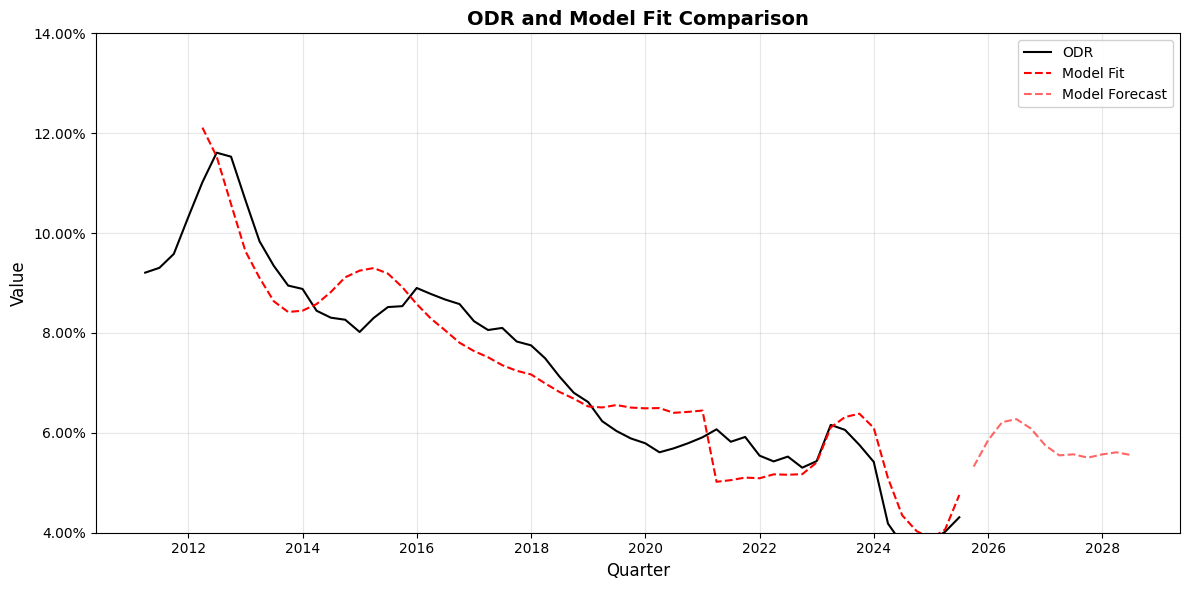


Plot saved to 'odr_model_fit_comparison.png'


In [18]:
# Create visualization matching the R package output
fig, ax = plt.subplots(figsize=(12, 6))

# Plot ODR (actual values - realized only)
odr_realized = db[db['TYPE'] == 'REALIZED']
ax.plot(odr_realized['QUARTER'], odr_realized['ODR'], 
        'k-', linewidth=1.5, label='ODR')

# Plot Model Fit (realized period)
fit_data = db[db['model_fit'].notna()]
ax.plot(fit_data['QUARTER'], fit_data['model_fit'], 
        'r--', linewidth=1.5, label='Model Fit')

# Plot Model Forecast (forecast period)
forecast_data = db[db['model_forecast'].notna()]
if len(forecast_data) > 0:
    # Connect the last fit point to the first forecast point
    last_fit_idx = fit_data.index[-1]
    ax.plot(forecast_data['QUARTER'], forecast_data['model_forecast'], 
            color='red', linestyle='--', linewidth=1.5, alpha=0.6, label='Model Forecast')

# Formatting
ax.set_xlabel('Quarter', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.set_title('ODR and Model Fit Comparison', fontsize=14, fontweight='bold')

# Format y-axis as percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.2%}'.format(y)))

# Add grid
ax.grid(True, alpha=0.3)

# Legend
ax.legend(loc='upper right', framealpha=0.9)

# Set y-axis limits similar to R output
ax.set_ylim([0.04, 0.14])

plt.tight_layout()
plt.savefig('odr_model_fit_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'odr_model_fit_comparison.png'")

## 5. Summary and Notes

### Key Results

This Python implementation successfully reproduces the SMI methodology from the R package `smi`:

1. **Data Processing**: Loaded 70 quarterly observations (58 realized, 12 forecast)
2. **Lagged Variables**: Created 16 lagged predictors (4 lags x 4 variables)
3. **Missing Observations**: First 4 observations (2011) excluded due to lag NaN values - only **54 realized observations** used for modeling
4. **Model Combinations**: Generated 670 valid predictor combinations
5. **Constrained OLS**: Estimated all models with sign constraints
6. **Model Filtering**: Excluded models with zero coefficients (constraint binding)
7. **SMI Construction**: Averaged coefficients across valid models
8. **FLI Model**: Fitted final model with SMI and DUMMY predictors (54 obs, 51 df)

### Differences from R Results

Small numerical differences between Python and R implementations are expected due to:
- Different optimization algorithms (Python uses L-BFGS-B, R uses quadprog)
- Floating-point precision differences
- Convergence tolerance settings

### Next Steps for Practitioners

As noted in the original documentation:
- Examine OLS assumptions (normality, heteroscedasticity, autocorrelation)
- Test alternative designs (dynamic regression, first differences)
- Review predictors with limited SMI contributions
- Validate model stability (rolling windows)
- Assess out-of-sample forecast accuracy

In [19]:
# Final summary statistics
print("="*60)
print("IMPLEMENTATION SUMMARY")
print("="*60)
print(f"\nDataset:")
print(f"  Total observations: {len(db)}")
print(f"  Realized observations: {(db['TYPE'] == 'REALIZED').sum()}")
print(f"  Forecast observations: {(db['TYPE'] == 'FORECAST').sum()}")
print(f"\nModel Combinations:")
print(f"  Total combinations: {len(gr_c)}")
print(f"  Models with zero coefficients: {me['zero.coeff'].sum()}")
print(f"  Valid models for SMI: {len(valid_models)}")
print(f"\nSMI Coefficients:")
print(f"  Total predictors contributing: {len(smi_coef) - 1}")
print(f"  Intercept: {smi_coef[smi_coef['coefficient'] == '(Intercept)']['estimate'].values[0]:.6f}")
print(f"\nFLI Model Performance:")
print(f"  R-squared: {fli_model.rsquared:.4f}")
print(f"  Adjusted R-squared: {fli_model.rsquared_adj:.4f}")
print(f"  F-statistic: {fli_model.fvalue:.2f}")

IMPLEMENTATION SUMMARY

Dataset:
  Total observations: 70
  Realized observations: 58
  Forecast observations: 12

Model Combinations:
  Total combinations: 670
  Models with zero coefficients: 423
  Valid models for SMI: 247

SMI Coefficients:
  Total predictors contributing: 19
  Intercept: 0.035617

FLI Model Performance:
  R-squared: 0.9010
  Adjusted R-squared: 0.8971
  F-statistic: 232.10
